In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.optim import Adam, SGD
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [2]:
df = pd.read_csv('data_akbilgic.csv')
df = df.drop("date", axis = 1).values

In [3]:
df

array([[ 0.03575371,  0.03837619, -0.00467931, ...,  0.03119023,
         0.01269804,  0.02852446],
       [ 0.02542587,  0.03181274,  0.00778674, ...,  0.01891958,
         0.01134065,  0.00877264],
       [-0.02886173, -0.02635297, -0.03046913, ..., -0.03589858,
        -0.0170728 , -0.02001541],
       ...,
       [ 0.00019097, -0.0016526 ,  0.00192291, ...,  0.00562792,
         0.00057157,  0.00693787],
       [-0.01306904, -0.01370599, -0.02074215, ..., -0.01194168,
        -0.01261533, -0.00095774],
       [-0.00724632, -0.01944185,  0.        , ..., -0.01225155,
        -0.00546489, -0.01429693]])

## Split data

In [4]:
df_size = int(df.shape[0] * 0.8)
df_train = df[: df_size]
df_test = df[df_size :]

## Batchify data

In [5]:
def next_stock_batch(batch_size, n_steps, df_base, n_features):
    t_max = df_base.shape[0]

    x = np.zeros((batch_size, n_steps, n_features))
    y = np.zeros((batch_size, n_steps))
    starting_points = np.random.randint(0, t_max-n_steps-1, size=batch_size)    
    #print(starting_points)
    
    # We create the batches for x using all time series (8) between t and t+n_steps 
    for i, sp in enumerate(starting_points):
        x[i] = df[sp:sp + n_steps]
        y[i] = df[sp + 1: sp + n_steps + 1, 1]

    return x, y

x, y = next_stock_batch(32, 5, df, df.shape[1])

print(x[0])

[[-0.00117923  0.0041029   0.00259991 -0.00142248 -0.00387392  0.00096329
   0.00343162 -0.00135864  0.00213372]
 [ 0.01266117  0.01035651 -0.00129911  0.00095813  0.00434194 -0.00109016
  -0.00307211 -0.00018458  0.00295121]
 [ 0.00238034  0.0081574   0.00051494  0.00681129  0.00659829 -0.00257333
  -0.00308158  0.00813522  0.00106852]
 [-0.00249096 -0.01246241  0.0036949  -0.00372592 -0.00241317  0.00895584
  -0.01691517  0.00156935 -0.00764955]
 [-0.02680508 -0.03185293  0.00383541 -0.00168005  0.00232709  0.00521977
  -0.00435122  0.00230703  0.00096821]]


## Model

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, seq_len):
        super().__init__()
        self.num_layer = num_layers
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.batch_size * self.hidden_size, 500)
        self.fc2 = nn.Linear(500, self.batch_size * self.seq_len)
    

    def forward(self, x):
        h0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))
        c0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h0, c0))
        last_hidden = hn[-1]
    

        x = F.tanh(last_hidden.flatten()) # added this line, you can activate also the last hidden layer, for better performance
        x = F.tanh(self.fc1(x))
        return self.fc2(x)


model = LSTM(9, 15, 10, 32, 5)

## Train

In [7]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr= 0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

c:\Users\ritth\software\anaconda\envs\deep\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1/500, MSE: 0.00243414007127285
Epoch: 51/500, MSE: 0.0006839037523604929
Epoch: 101/500, MSE: 0.00042875847429968417
Epoch: 151/500, MSE: 0.00041504958062432706
Epoch: 201/500, MSE: 0.0007018448086455464
Epoch: 251/500, MSE: 0.0005316176102496684
Epoch: 301/500, MSE: 0.000411530549172312
Epoch: 351/500, MSE: 0.00041910429717972875
Epoch: 401/500, MSE: 0.0005601922748610377
Epoch: 451/500, MSE: 0.0004825814685318619


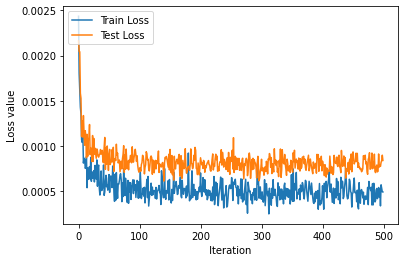

In [8]:
n_iterations = 500
printing_gap = 50
train_losses = []
test_losses = []

for iter in range(n_iterations):
    
    model.train()  
    # Get a batch
    x_train, y_train = next_stock_batch(32, 5, df_train, df.shape[1])

    # make into tensor
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float().flatten()


    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.detach().item())


    if iter % printing_gap == 0:
        print(f'Epoch: {iter + 1}/{n_iterations}, MSE: {loss.item()}')

    model.eval()
    with torch.no_grad():
        x_test, y_test = next_stock_batch(32, 5, df_test, df.shape[1])
        x_test = torch.from_numpy(x_test).float()
        y_test = torch.from_numpy(y_test).float().flatten()

        test_pred = model(x_test)
        test_loss = criterion(test_pred, y_test)
        test_losses.append(test_loss.detach().item())
    scheduler.step()


plt.plot(train_losses, label= "Train Loss")
plt.plot(test_losses, label= "Test Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()

In [9]:
torch.save(model.state_dict(), 'checkpoint.pth')